In [2]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.metrics import jaccard_score, f1_score

In [3]:
# Function to segment image using Gaussian Mixture Model (GMM)
def gmm_segmentation(image, components=2):
    gray_img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    pixel_values = gray_img.reshape(-1, 1).astype(np.float32)

    # Apply Gaussian Mixture Model
    gmm = GaussianMixture(n_components=components, covariance_type="tied", random_state=42)
    gmm.fit(pixel_values)
    labels = gmm.predict(pixel_values)

    # Convert labels to image mask
    segmented_mask = labels.reshape(gray_img.shape)
    cluster_means = [np.mean(gray_img[segmented_mask == i]) for i in range(components)]
    mask_label = np.argmax(cluster_means)  # Select the cluster with the highest intensity as the mask
    mask = (segmented_mask == mask_label).astype(np.uint8) * 255
    return torch.tensor(mask, dtype=torch.uint8)

In [4]:

# Function to segment image using Otsu’s thresholding
def otsu_segmentation(image):
    gray_img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    _, mask = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return torch.tensor(mask, dtype=torch.uint8)

# Function to segment image using Watershed Algorithm
def watershed_segmentation(image):
    gray_img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    _, binary_mask = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Noise removal and background identification
    kernel = np.ones((3, 3), np.uint8)
    clean_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel, iterations=2)
    sure_bg = cv2.dilate(clean_mask, kernel, iterations=3)

    # Foreground detection
    dist_transform = cv2.distanceTransform(clean_mask, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, 0.5 * dist_transform.max(), 255, 0)
    
    sure_fg = np.uint8(sure_fg)
    unknown_region = cv2.subtract(sure_bg, sure_fg)

    # Marker labeling and Watershed application
    _, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown_region == 255] = 0

    image_copy = image.copy()
    cv2.watershed(image_copy, markers)
    mask = np.uint8(markers > 1) * 255
    
    return torch.tensor(mask, dtype=torch.uint8)

# Function to compute IoU and Dice Score
def evaluate_segmentation(predicted_mask, ground_truth):
    predicted_mask = (predicted_mask > 0).flatten().numpy()
    ground_truth = (ground_truth > 0).flatten().numpy()

    iou_score = jaccard_score(ground_truth, predicted_mask)
    dice_score = f1_score(ground_truth, predicted_mask)  

    return iou_score, dice_score



--- Image: 000000_1.jpg ---
Original Image:


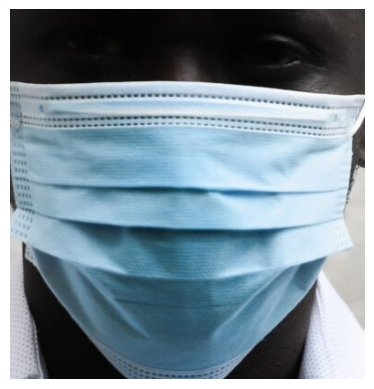

Ground Truth Mask:


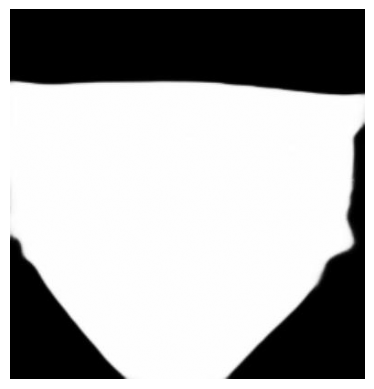

GMM Segmented Image:


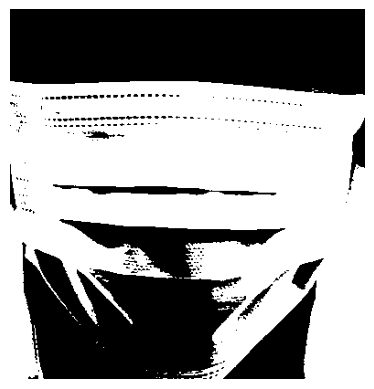

  GMM: IoU=0.6516, Dice=0.7891
Otsu Segmented Image:


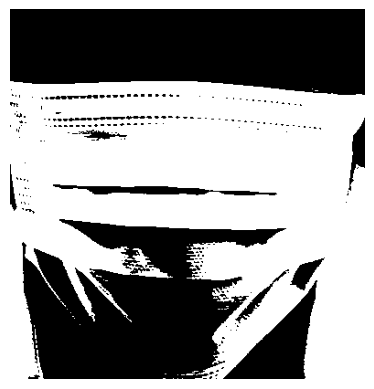

  Otsu: IoU=0.6395, Dice=0.7801
Watershed Segmented Image:


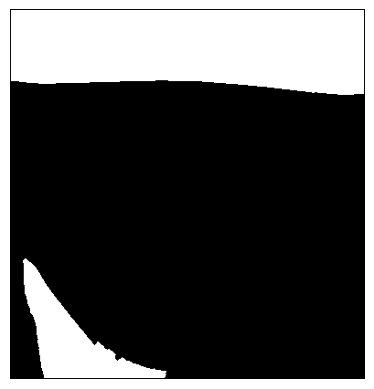

  Watershed: IoU=0.0235, Dice=0.0459
--- Image: 000001_1.jpg ---
Original Image:


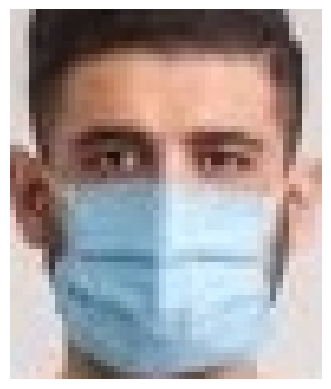

Ground Truth Mask:


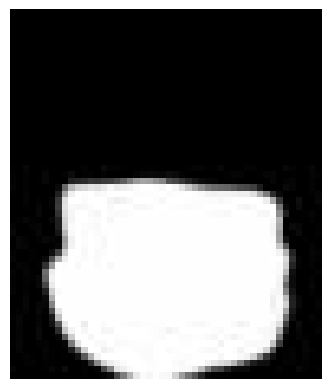

GMM Segmented Image:


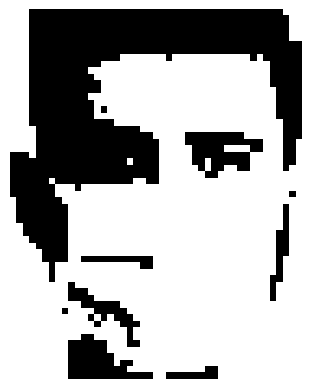

  GMM: IoU=0.5354, Dice=0.6974
Otsu Segmented Image:


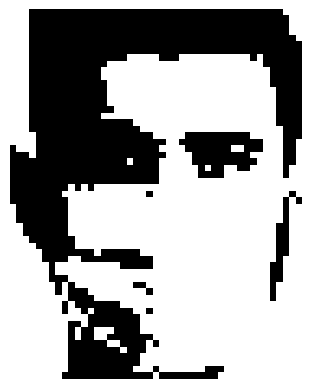

  Otsu: IoU=0.5060, Dice=0.6720
Watershed Segmented Image:


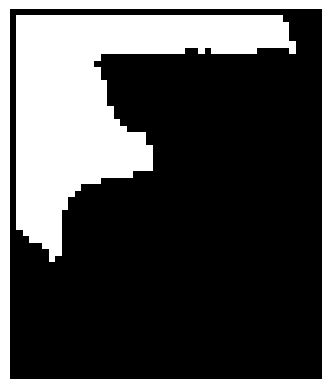

  Watershed: IoU=0.0347, Dice=0.0670
--- Image: 000002_1.jpg ---
Original Image:


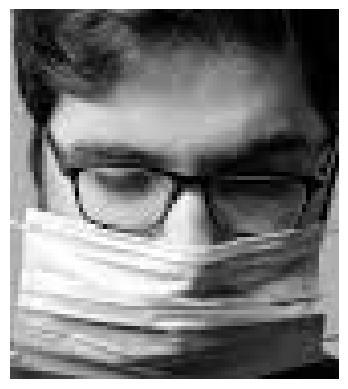

Ground Truth Mask:


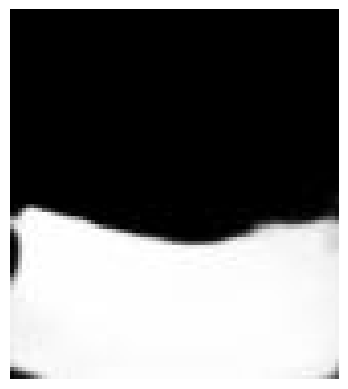

GMM Segmented Image:


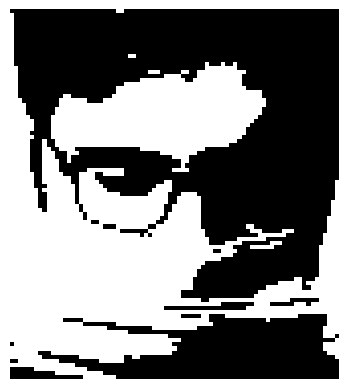

  GMM: IoU=0.4154, Dice=0.5870
Otsu Segmented Image:


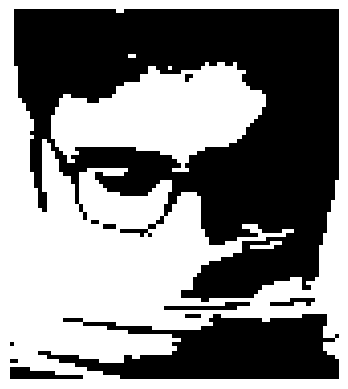

  Otsu: IoU=0.4184, Dice=0.5899
Watershed Segmented Image:


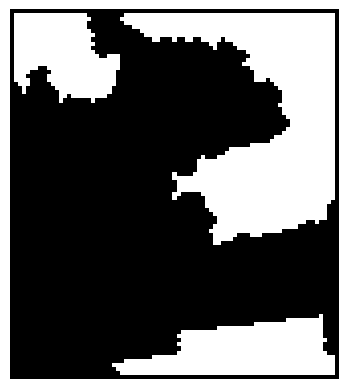

  Watershed: IoU=0.1386, Dice=0.2435
--- Image: 000003_1.jpg ---
Original Image:


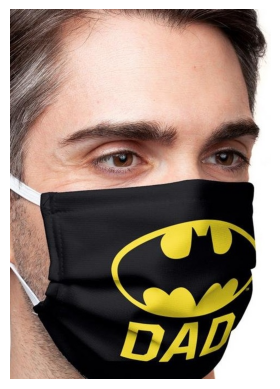

Ground Truth Mask:


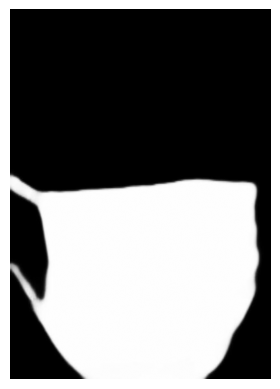

GMM Segmented Image:


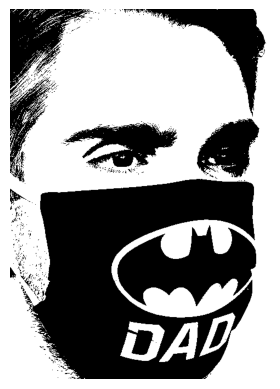

  GMM: IoU=0.1301, Dice=0.2302
Otsu Segmented Image:


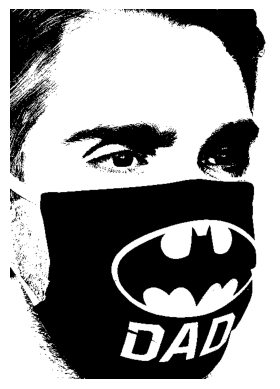

  Otsu: IoU=0.1298, Dice=0.2298
Watershed Segmented Image:


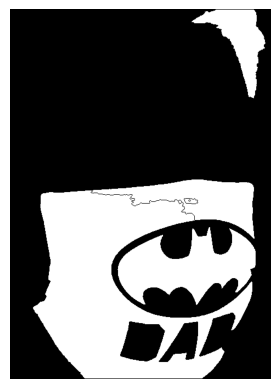

  Watershed: IoU=0.6561, Dice=0.7924
--- Image: 000004_1.jpg ---
Original Image:


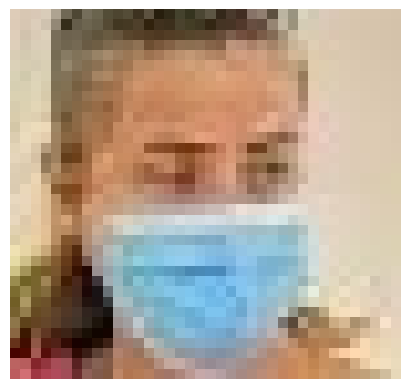

Ground Truth Mask:


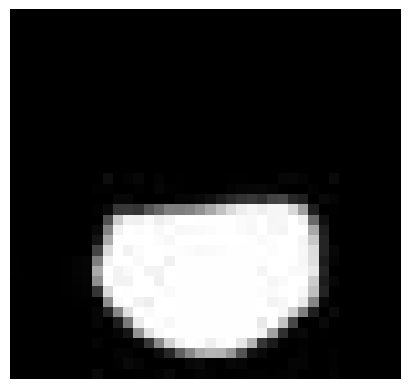

GMM Segmented Image:


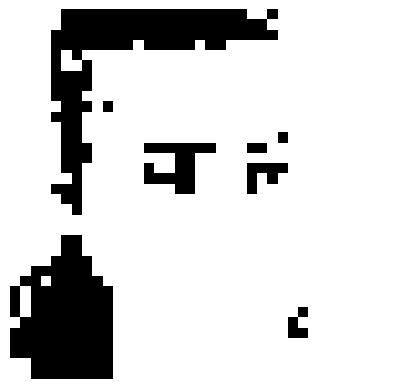

  GMM: IoU=0.3293, Dice=0.4954
Otsu Segmented Image:


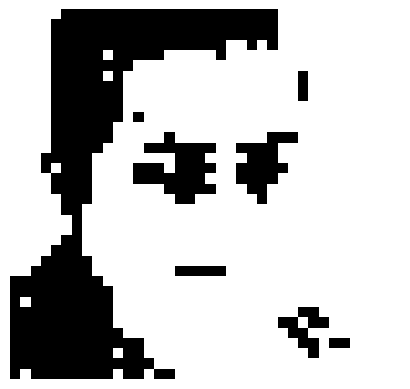

  Otsu: IoU=0.3378, Dice=0.5050
Watershed Segmented Image:


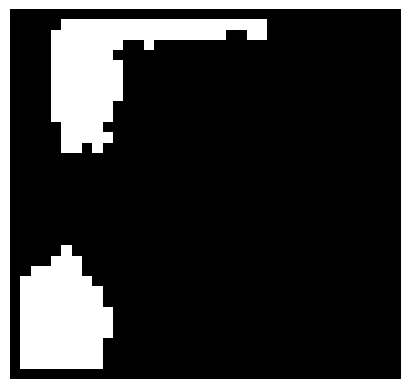

  Watershed: IoU=0.0328, Dice=0.0634

Mean Segmentation Performance for all images:
  - GMM: IoU = 0.3600, Dice = 0.4949
  - Otsu: IoU = 0.3669, Dice = 0.5037
  - Watershed: IoU = 0.1422, Dice = 0.2013


In [ ]:
# Paths to dataset
image_folder = "/home/rampe4/dataset_new/MSFD/1/face_crop"
mask_folder = "/home/rampe4/dataset_new/MSFD/1/face_crop_segmentation"

# Lists to store IoU and Dice scores
iou_gmm_scores, dice_gmm_scores = [], []
iou_otsu_scores, dice_otsu_scores = [], []
iou_watershed_scores, dice_watershed_scores = [], []
count = 0

# Sort and limit to the first 5 images for demonstration
image_list = sorted(os.listdir(image_folder))
mask_list = sorted(os.listdir(mask_folder))

# Loop through the first 5 images
for i, (img_name, gt_name) in enumerate(zip(image_list, mask_list)):
    if img_name.lower().endswith((".jpg", ".png", ".jpeg")):
    
        img_path = os.path.join(image_folder, img_name)
        gt_path = os.path.join(mask_folder, gt_name)

        image = cv2.imread(img_path)
        if image is None:
            print(f"Error loading image: {img_name}")
            continue

        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ground_truth_mask = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)

        if ground_truth_mask is None:
            print(f"Error loading mask: {gt_name}")
            continue

        ground_truth_mask_tensor = torch.tensor(ground_truth_mask, dtype=torch.uint8)

        # Apply segmentation methods and handle errors
        try:
            count = count + 1
            gmm_mask = gmm_segmentation(image_rgb)
            otsu_mask = otsu_segmentation(image_rgb)
            watershed_mask = watershed_segmentation(image_rgb)

            h, w = ground_truth_mask_tensor.shape

            # Resize masks to match ground truth size
            gmm_mask_resized = cv2.resize(gmm_mask.numpy(), (w, h), interpolation=cv2.INTER_NEAREST)
            otsu_mask_resized = cv2.resize(otsu_mask.numpy(), (w, h), interpolation=cv2.INTER_NEAREST)
            watershed_mask_resized = cv2.resize(watershed_mask.numpy(), (w, h), interpolation=cv2.INTER_NEAREST)

            # Convert back to tensors
            gmm_mask_tensor = torch.tensor(gmm_mask_resized, dtype=torch.uint8)
            otsu_mask_tensor = torch.tensor(otsu_mask_resized, dtype=torch.uint8)
            watershed_mask_tensor = torch.tensor(watershed_mask_resized, dtype=torch.uint8)

            # Evaluate segmentation performance
            iou_gmm, dice_gmm = evaluate_segmentation(gmm_mask_tensor > 0, ground_truth_mask_tensor > 0)
            iou_otsu, dice_otsu = evaluate_segmentation(otsu_mask_tensor > 0, ground_truth_mask_tensor > 0)
            iou_watershed, dice_watershed = evaluate_segmentation(watershed_mask_tensor > 0, ground_truth_mask_tensor > 0)

            # Store scores
            iou_gmm_scores.append(iou_gmm)
            dice_gmm_scores.append(dice_gmm)
            iou_otsu_scores.append(iou_otsu)
            dice_otsu_scores.append(dice_otsu)
            iou_watershed_scores.append(iou_watershed)
            dice_watershed_scores.append(dice_watershed)

            if count < 6:
                print(f"--- Image: {img_name} ---")
                print("Original Image:")
                plt.imshow(image_rgb)
                plt.axis('off')
                plt.show()

                print("Ground Truth Mask:")
                plt.imshow(ground_truth_mask, cmap='gray')
                plt.axis('off')
                plt.show()

                print("GMM Segmented Image:")
                plt.imshow(gmm_mask_resized, cmap='gray')
                plt.axis('off')
                plt.show()
                print(f"  GMM: IoU={iou_gmm:.4f}, Dice={dice_gmm:.4f}")

                print("Otsu Segmented Image:")
                plt.imshow(otsu_mask_resized, cmap='gray')
                plt.axis('off')
                plt.show()
                print(f"  Otsu: IoU={iou_otsu:.4f}, Dice={dice_otsu:.4f}")

                print("Watershed Segmented Image:")
                plt.imshow(watershed_mask_resized, cmap='gray')
                plt.axis('off')
                plt.show()
                print(f"  Watershed: IoU={iou_watershed:.4f}, Dice={dice_watershed:.4f}")

        except Exception as e:
            print(f"Error processing {img_name}: {e}")
            continue

# Compute mean scores
mean_iou_gmm = np.mean(iou_gmm_scores) if iou_gmm_scores else 0
mean_dice_gmm = np.mean(dice_gmm_scores) if dice_gmm_scores else 0
mean_iou_otsu = np.mean(iou_otsu_scores) if iou_otsu_scores else 0
mean_dice_otsu = np.mean(dice_otsu_scores) if dice_otsu_scores else 0
mean_iou_watershed = np.mean(iou_watershed_scores) if iou_watershed_scores else 0
mean_dice_watershed = np.mean(dice_watershed_scores) if dice_watershed_scores else 0

# Print final mean scores
print("\nMean Segmentation Performance for all images:")
print(f"  - GMM: IoU = {mean_iou_gmm:.4f}, Dice = {mean_dice_gmm:.4f}")
print(f"  - Otsu: IoU = {mean_iou_otsu:.4f}, Dice = {mean_dice_otsu:.4f}")
print(f"  - Watershed: IoU = {mean_iou_watershed:.4f}, Dice = {mean_dice_watershed:.4f}")